In [ ]:
from transformers import BertTokenizer
from transformers import AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import joblib
from torch.optim import AdamW
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torcheval.metrics import MultilabelAccuracy
import torch
from prettytable import PrettyTable
import numpy as np

import seaborn as sns

In [ ]:
train_df = joblib.load('data/train_df.joblib')
test_df = joblib.load('data/test_df.joblib')

In [ ]:
category_idx_to_text = {0: 'ambience', 1: 'food', 2: 'other', 3: 'price', 4: 'service'}
polarity_idx_to_text = {0: 'negative', 1: 'neutral', 2: 'positive'}
joint_idx_to_text = {0: 'ambience#negative', 1: 'ambience#neutral', 2: 'ambience#positive', 3: 'food#negative', 4: 'food#neutral', 5: 'food#positive', 6: 'other#negative', 7: 'other#neutral', 8: 'other#positive', 9: 'price#negative', 10: 'price#neutral', 11: 'price#positive', 12: 'service#negative', 13: 'service#neutral', 14: 'service#positive'}

In [ ]:
train_df.head()

,text,category,polarity,joint,category_labels,polarity_labels,joint_labels
0,staff horrible us,[service],[negative],[service#negative],"[0, 0, 0, 0, 1]","[1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
1,completely fair redeeming factor food average ...,"[food, other]","[positive, negative]","[food#positive, other#negative]","[0, 1, 1, 0, 0]","[1, 0, 1]","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,food uniformly exceptional capable kitchen pro...,[food],[positive],[food#positive],"[0, 1, 0, 0, 0]","[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,gabriela personaly greets recommends eat,[service],[positive],[service#positive],"[0, 0, 0, 0, 1]","[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,go enjoy say get,[other],[positive],[other#positive],"[0, 0, 1, 0, 0]","[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


In [ ]:
train_text = train_df['text'].tolist()
test_text = test_df['text'].tolist()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Tokenize input data
tokenized_train_text = tokenizer(train_text,
                                 return_tensors='pt',  # Return PyTorch tensors
                                 max_length=180,
                                 truncation=True,
                                 padding='max_length',
                                 )

tokenized_test_text = tokenizer(test_text,
                                 return_tensors='pt',  # Return PyTorch tensors
                                 max_length=180,
                                 truncation=True,
                                 padding='max_length',
                                 )


In [ ]:
tokenized_train_text

{'input_ids': tensor([[  101,  3095,  9202,  ...,     0,     0,     0],
        [  101,  3294,  4189,  ...,     0,     0,     0],
        [  101,  2833, 27423,  ...,     0,     0,     0],
        ...,
        [  101,  3369,  7610,  ...,     0,     0,     0],
        [  101,  2795,  8962,  ...,     0,     0,     0],
        [  101,  2183,  3054,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, tokenized_input, labels):
        self.tokenized_input = tokenized_input
        self.labels = labels

    def __len__(self):
        return len(self.tokenized_input['input_ids'])

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_input['input_ids'][idx],
            'attention_mask': self.tokenized_input['attention_mask'][idx],
            'token_type_ids': self.tokenized_input['token_type_ids'][idx],
            'labels': torch.tensor(self.labels[idx]),
        }

## Joint classification

In [ ]:
train_joint_labels = train_df['joint_labels'].apply(lambda x: [np.float32(i) for i in x]).tolist()
test_joint_labels= test_df['joint_labels'].apply(lambda x: [np.float32(i) for i in x]).tolist()

In [ ]:
train_dataset = CustomDataset(tokenized_train_text, train_joint_labels)
test_dataset = CustomDataset(tokenized_test_text, test_joint_labels)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
train_dataset[0]

{'input_ids': tensor([ 101, 3095, 9202, 2149,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0, 

In [ ]:
learning_rate = 1e-5
batch_size = 8
metric_name = "micro_f1"

In [ ]:
tokenizer.decode(train_dataset[0]['input_ids'])

'[CLS] staff horrible us [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',
                                                           problem_type='multi_label_classification',
                                                           num_labels=15,
                                                           id2label=joint_idx_to_text,
                                                           label2id={v: k for k, v in joint_idx_to_text.items()})

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)

In [ ]:
args = TrainingArguments(
    f'bert-finetuned-sem_eval-english',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    optim='adamw_torch'
)

In [ ]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels

    accuracy = accuracy_score(y_true, y_pred)

    exact_accuracy = MultilabelAccuracy(criteria='exact_match')
    exact_accuracy.update(target=torch.Tensor(y_true), input=torch.Tensor(y_pred))

    overlap_accuracy = MultilabelAccuracy(criteria='overlap')
    overlap_accuracy.update(target=torch.Tensor(y_true), input=torch.Tensor(y_pred))

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')

    metrics = {}
    metrics = {
        'accuracy' : accuracy,
        'exact_match_accuracy': exact_accuracy.compute().detach().item(),
        'overlap_accuracy': overlap_accuracy.compute().detach().item(),
        'macro_f1': macro_f1,
        'micro_f1': micro_f1
    }


    return metrics


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result


def pretty_table(dict):
    table = PrettyTable()
    table.field_names = ['metric', 'value']
    for k,v in dict.items():
        table.add_row([k, v])
    print(table)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Exact Match Accuracy,Overlap Accuracy,Macro F1,Micro F1
1,No log,0.226649,0.208278,0.208278,0.301736,0.051334,0.363052
2,0.288500,0.197096,0.218959,0.218959,0.332443,0.105069,0.432258
3,0.196400,0.166405,0.356475,0.356475,0.479306,0.196430,0.564875
4,0.196400,0.147412,0.439252,0.439252,0.580774,0.266466,0.626649
5,0.156400,0.137081,0.506008,0.506008,0.648865,0.319529,0.668329
6,0.122200,0.132778,0.584780,0.584780,0.692924,0.402439,0.713703
7,0.122200,0.130309,0.578104,0.578104,0.700935,0.419192,0.711292
8,0.097200,0.131166,0.583445,0.583445,0.710280,0.425316,0.712894
9,0.080400,0.129358,0.588785,0.588785,0.715621,0.433692,0.717890
10,0.067200,0.131543,0.583445,0.583445,0.704940,0.462421,0.715429


TrainOutput(global_step=7140, training_loss=0.09293063348080932, metrics={'train_runtime': 2364.7488, 'train_samples_per_second': 24.129, 'train_steps_per_second': 3.019, 'total_flos': 5278664944749600.0, 'train_loss': 0.09293063348080932, 'epoch': 20.0})

In [ ]:
pretty_table(trainer.evaluate())

+---------------------------+---------------------+
|           metric          |        value        |
+---------------------------+---------------------+
|         eval_loss         | 0.13262231647968292 |
|       eval_accuracy       |  0.6128170894526035 |
| eval_exact_match_accuracy |  0.612817108631134  |
|   eval_overlap_accuracy   |  0.743658185005188  |
|       eval_macro_f1       |  0.4932365879489153 |
|       eval_micro_f1       |  0.7334446299387868 |
|        eval_runtime       |        8.7618       |
|  eval_samples_per_second  |        85.484       |
|   eval_steps_per_second   |        10.728       |
|           epoch           |         20.0        |
+---------------------------+---------------------+


In [ ]:
# Taken from the training table above

train_loss = [0.288500, 0.288500, 0.196400, 0.196400, 0.156400, 0.122200, 0.122200, 0.097200, 0.080400, 0.067200, 0.067200, 0.059500, 0.051100, 0.051100, 0.046300, 0.041700, 0.038900, 0.038900, 0.036400, 0.035300]
val_loss = [0.226649, 0.197096, 0.166405, 0.147412, 0.137081, 0.132778, 0.130309, 0.131166, 0.129358, 0.131543, 0.129146, 0.131163, 0.131546, 0.132622, 0.134013, 0.133932, 0.135100, 0.136442, 0.135168, 0.135675]

In [ ]:
from matplotlib import pyplot as plt

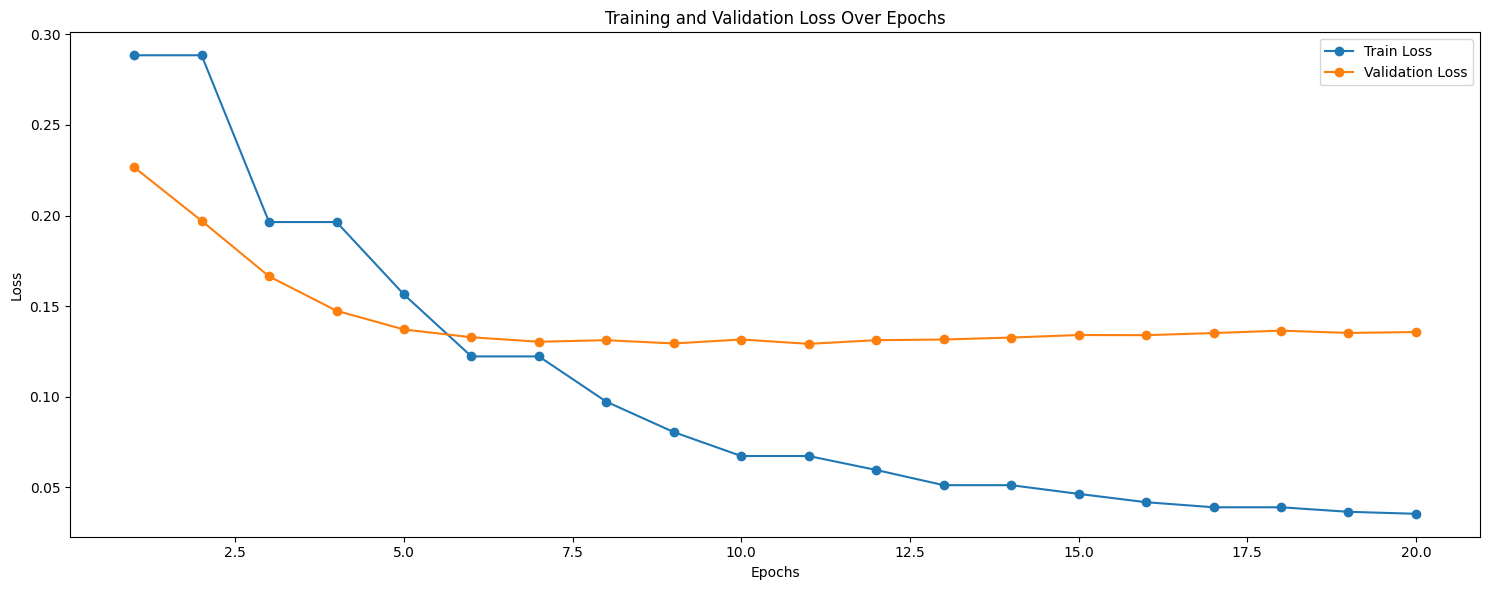

In [ ]:
epochs = list(range(1, len(train_loss) + 1))
plt.figure(figsize=(15, 6))

# Plot train loss
plt.plot(epochs, train_loss, label='Train Loss', marker='o')

# Plot validation loss
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')

# Set plot labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')

# Display legend
plt.legend()

# Show the plot
plt.grid(False)
plt.tight_layout()
plt.savefig('bert_joint_plot.png')
plt.show()